### This notebook contains supporting statistical analyses referenced in the main  profitability analysis. It is not intended to be read independently.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

data_path = r"D:\Data_analysis_BI\Project\Superstore_analysis\data\processed\superstore_processed.parquet"

df = pd.read_parquet(data_path)

In [2]:
# Ensure datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Extract time features
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.to_period('Q')
df['Week'] = df['Order Date'].dt.isocalendar().week

# Lead time
df['Ship Delay (Days)'] = (df['Ship Date'] - df['Order Date']).dt.days

In [ ]:

from scipy import stats

# Assuming df already loaded
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Order-level aggregation (one row per order)
# Because each row in the original dataset is not an independent order. Statistical tests assume independent observations.
orders = (
    df.groupby('Order ID')
      .agg({
          'Sales': 'sum',
          'Profit': 'sum',
          'Discount': 'mean',      # avg discount in that order
          'Segment': 'first',
          'Region': 'first',
          'Order Date': 'first'
      })
      .reset_index()
)

orders['Profit_Margin'] = orders['Profit'] / orders['Sales']
orders['Year'] = orders['Order Date'].dt.year
orders['Quarter'] = orders['Order Date'].dt.to_period('Q')


### Test 1: Impact of Discount on Profit Margin

**Question:**  
Do discounted orders have a significantly different (lower) profit margin compared to non-discounted orders?

**Groups:**
- Group A: Orders with no discount (Discount = 0)
- Group B: Orders with discount (Discount > 0)

We perform:
- An independent t-test (Welch's t-test, unequal variances)
- We also report effect size (Cohen's d)


In [4]:
# Define groups
group_A = orders.loc[orders['Discount'] == 0, 'Profit_Margin'].dropna()
group_B = orders.loc[orders['Discount'] > 0, 'Profit_Margin'].dropna()

print("Group sizes:", len(group_A), len(group_B))

# Basic descriptives
print("No discount - mean margin:", group_A.mean())
print("Discount - mean margin:", group_B.mean())

# Welch's t-test
t_stat, p_val = stats.ttest_ind(group_A, group_B, equal_var=False)
print("\nWelch t-test:")
print("t-statistic:", t_stat)
print("p-value:", p_val)

# Effect size: Cohen's d (using pooled SD)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.var(x, ddof=1), np.var(y, ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx + (ny-1)*sy) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / s_pooled

d = cohens_d(group_A, group_B)
print("Cohen's d (No discount - Discount):", d)


Group sizes: 2055 2954
No discount - mean margin: 0.327491242961666
Discount - mean margin: -0.035857062567432985

Welch t-test:
t-statistic: 39.74026481182199
p-value: 8.447140937798845e-286
Cohen's d (No discount - Discount): 0.9756255207775429


### Discounted orders have significantly lower profit margins than non-discounted orders (p ≪ 0.001), and the effect size is large (Cohen’s d ≈ 0.98). This means discounting is not just statistically harmful but financially severe, frequently driving orders into negative profit.

### Test 1a: Relationship Between Discount and Profit Margin

We fit a simple linear regression at the order level:

Profit_Margin = β₀ + β₁ * Discount + ε

A significantly negative β₁ would support the claim that higher discounts tend to reduce profit margin.


                            OLS Regression Results                            
Dep. Variable:          Profit_Margin   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 1.063e+04
Date:                Wed, 03 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:50:26   Log-Likelihood:                 174.02
No. Observations:                5009   AIC:                            -344.0
Df Residuals:                    5007   BIC:                            -331.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3931      0.004     91.946      0.0

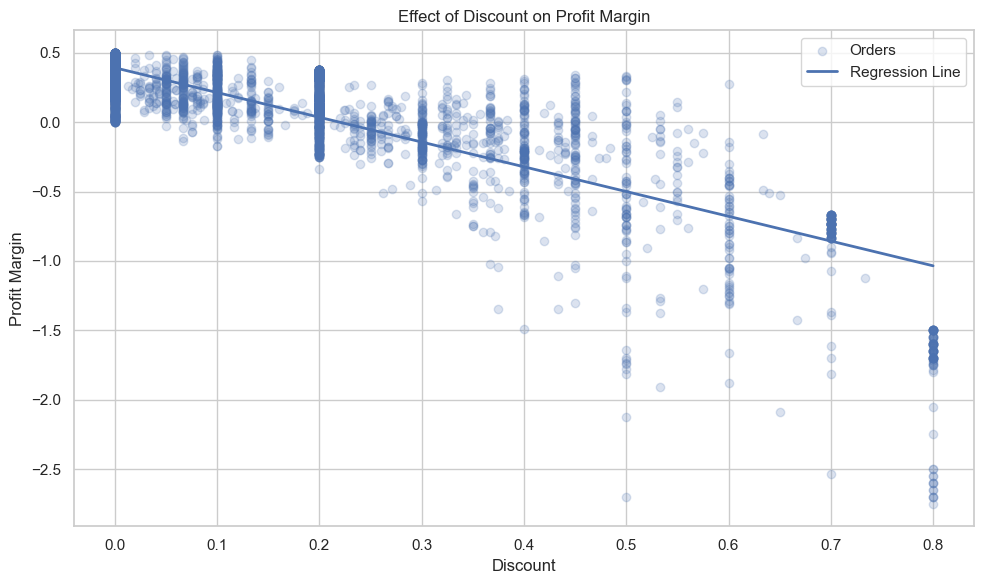

In [11]:
import statsmodels.api as sm

reg_data = orders[['Profit_Margin', 'Discount']].dropna()

X = reg_data['Discount']
y = reg_data['Profit_Margin']

X = sm.add_constant(X)  # adds intercept
model = sm.OLS(y, X).fit()

print(model.summary())
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(reg_data['Discount'], reg_data['Profit_Margin'], 
            alpha=0.2, label='Orders')

# Regression line
x_vals = np.linspace(reg_data['Discount'].min(), reg_data['Discount'].max(), 100)
X_line = sm.add_constant(x_vals)
y_pred = model.predict(X_line)

plt.plot(x_vals, y_pred, linewidth=2, label='Regression Line')

plt.title("Effect of Discount on Profit Margin")
plt.xlabel("Discount")
plt.ylabel("Profit Margin")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Regression Result Interpretation

Discount has a very strong and highly significant negative effect on profit margin (β = -1.78, p < 0.001). The model explains 68% of the variation in order profitability (R² = 0.68), which indicates that discounting is the primary driver of margin decline. A typical 10% discount reduces the profit margin by about 18 percentage points, and discounts above ~20% often push the order into negative profit. This confirms that discount-heavy sales are a major source of margin loss.


### Test 2: Difference in Profitability by Customer Segment

**Question:**  
Is the average profit margin per order different across segments?

**Groups:**
- Consumer
- Corporate
- Home Office

We use:
- One-way ANOVA as a first pass
- If assumptions are shaky, also compare with a non-parametric Kruskal–Wallis test

The dataset labels customers into three segments (Consumer, Corporate, Home Office). We use a One-Way ANOVA to determine whether the average profit margin per order is significantly different between these customer groups. This prevents inflated error risk that would occur if multiple pairwise t-tests were used.



In [5]:
# Prepare segment groups
segments = orders['Segment'].unique()
segment_groups = [orders.loc[orders['Segment'] == s, 'Profit_Margin'].dropna()
                  for s in segments]

for s, g in zip(segments, segment_groups):
    print(f"{s}: n={len(g)}, mean margin={g.mean()}")

# One-way ANOVA
f_stat, p_val = stats.f_oneway(*segment_groups)
print("\nANOVA:")
print("F-statistic:", f_stat)
print("p-value:", p_val)

# Non-parametric: Kruskal-Wallis (robust to non-normality)
h_stat, p_val_kw = stats.kruskal(*segment_groups)
print("\nKruskal-Wallis:")
print("H-statistic:", h_stat)
print("p-value:", p_val_kw)


Consumer: n=2586, mean margin=0.1045497507778549
Corporate: n=1514, mean margin=0.11506652534317406
Home Office: n=909, mean margin=0.1347594791869397

ANOVA:
F-statistic: 1.8212564295513385
p-value: 0.16192951177837747

Kruskal-Wallis:
H-statistic: 10.59439405002603
p-value: 0.005005604846760167


### Profitability across customer segments is broadly similar on average(ANOVA p=0.16, insygnificant), but the Home Office segment tends to achieve slightly higher profit margins(according to Krushal-Wallis test, p=0.005) and fewer extremely low-margin orders compared to the other segments. This can further be confirmed via following visualizations

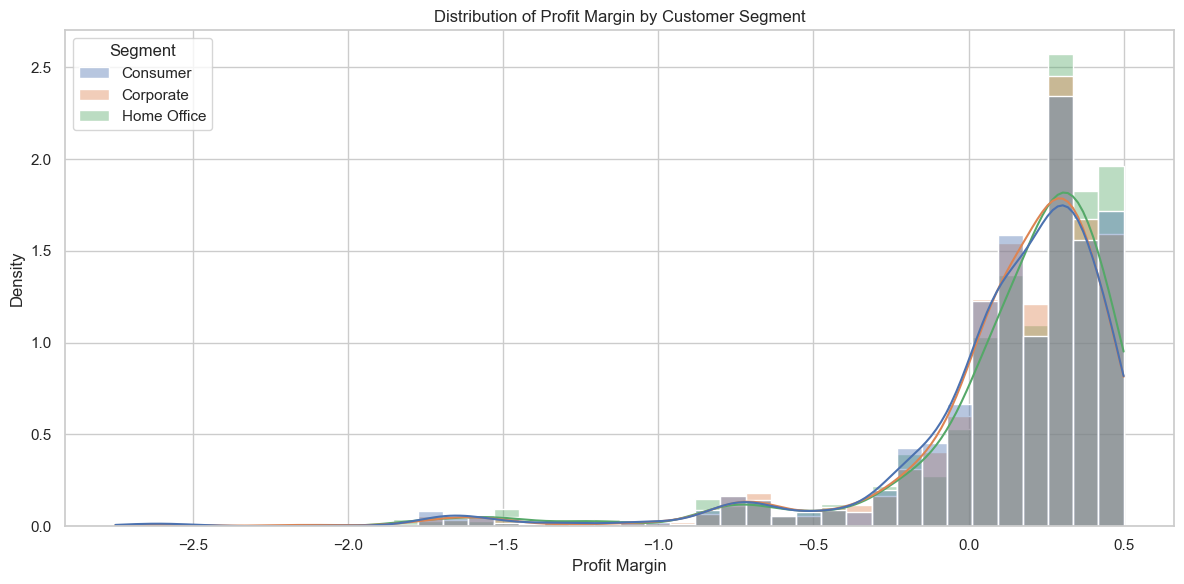

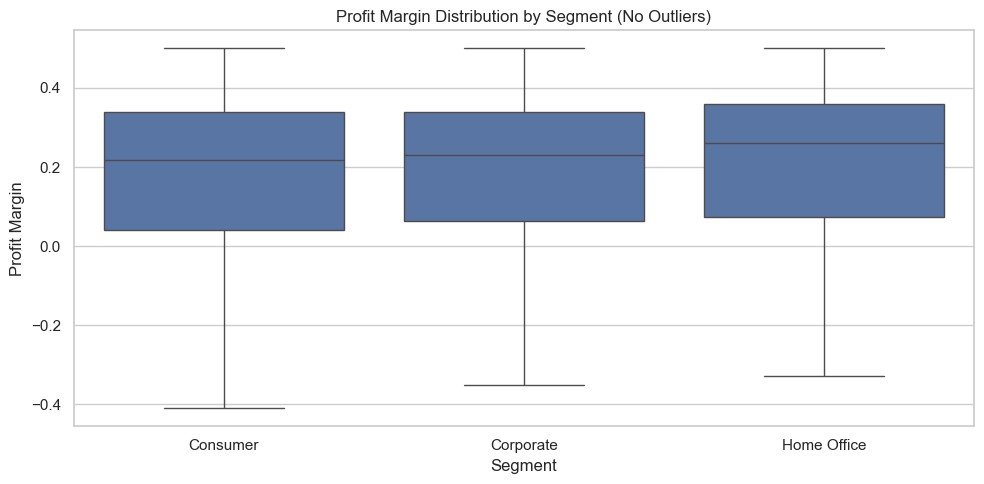

In [ ]:


sns.set(style="whitegrid")

plt.figure(figsize=(12,6))
sns.histplot(
    data=orders,
    x='Profit_Margin',
    hue='Segment',
    kde=True,
    stat='density',
    common_norm=False,
    bins=40,
    alpha=0.4
)

plt.title("Distribution of Profit Margin by Customer Segment")
plt.xlabel("Profit Margin")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(
    data=orders,
    x='Segment',
    y='Profit_Margin',
    showfliers=False   # hide extreme values/outliers
)
plt.title("Profit Margin Distribution by Segment (No Outliers)")
plt.xlabel("Segment")
plt.ylabel("Profit Margin")
plt.tight_layout()
plt.show()



### Test 3: Is Q4 More Profitable Than Other Quarters?

**Question:**  
Are orders in Q4 more profitable (higher profit margin) than orders in Q1–Q3 combined?

**Groups:**
- Q4 orders
- Non-Q4 orders (Q1, Q2, Q3)

We use Welch's t-test on order-level profit margin.


In [9]:
# Identify Q4 vs non-Q4
orders['Quarter_str'] = orders['Quarter'].astype(str)
is_q4 = orders['Quarter_str'].str.endswith('Q4')

q4_margin = orders.loc[is_q4, 'Profit_Margin'].dropna()
non_q4_margin = orders.loc[~is_q4, 'Profit_Margin'].dropna()

print("Q4 n, mean:", len(q4_margin), q4_margin.mean())
print("Non-Q4 n, mean:", len(non_q4_margin), non_q4_margin.mean())

t_stat, p_val = stats.ttest_ind(q4_margin, non_q4_margin, equal_var=False)
print("\nWelch t-test (Q4 vs non-Q4):")
print("t-statistic:", t_stat)
print("p-value:", p_val)

d_q4 = cohens_d(q4_margin, non_q4_margin)
print("Cohen's d (Q4 - non-Q4):", d_q4)


Q4 n, mean: 1872 0.10718248141055182
Non-Q4 n, mean: 3137 0.11680814034474768

Welch t-test (Q4 vs non-Q4):
t-statistic: -0.7932851907000079
p-value: 0.42766039885038776
Cohen's d (Q4 - non-Q4): -0.023302205717231773


##### Although overall profit increases in Q4 at a company level, the order-level Welch t-test shows no statistically significant difference in average profit margin between Q4 and the rest of the year (p = 0.43, Cohen’s d ≈ 0.02). This indicates that Q4 profit growth is driven by a higher number of orders rather than better profit margins per order.


### Q4 is not a margin advantage quarter, it is a demand spike quarter. Total revenue and total profit rise in Q4 primarily because more items and more orders are placed, not because orders themselves are more profitable.

## Final Interpretation and Takeaway

The statistical tests show that discounting is the primary factor impacting profitability in Superstore orders. Orders that receive discounts typically become unprofitable, and regression analysis confirms that discount levels explain most of the variation in profit margin. 

Customer segments do not differ meaningfully in average profitability, and while Q4 generates higher total profit, this is due to higher order volume rather than better profit per order. Therefore, both seasonal increases and segment differences are secondary effects compared to the impact of discounting.

**Overall:** Profitability is not a seasonal or segment-driven outcome — it is a pricing outcome. Reducing unnecessary discounts or applying them more strategically is critical to preventing profit loss.
